# Detección de Anomalías

En este ejercicio, implementarás el algoritmo de detección de anomalías y lo aplicarás para detectar servidores fallando en una red.



# Contenido
- [ 1 - Paquetes ](#1)
- [ 2 - Detección de anomalías](#2)
  - [ 2.1 Planteamiento del problema](#2.1)
  - [ 2.2  Conjunto de datos](#2.2)
  - [ 2.3 Distribución Gaussiana](#2.3)
    - [ Ejercicio 1](#ex01)
    - [ Ejercicio 2](#ex02)
  - [ 2.4 Conjunto de datos de alta dimensión](#2.4)


_**NOTA:** Para evitar errores con el autocalificador, no se permite editar ni eliminar celdas no calificadas en este ejercicio. Por favor, tampoco agregues nuevas celdas.
**Una vez que hayas aprobado este ejercicio** y quieras experimentar con cualquier código no calificado, puedes seguir las instrucciones al final de este cuaderno._

<a name="1"></a>
## 1 - Paquetes 

Primero, ejecuta la siguiente celda para importar todos los paquetes que necesitarás durante este ejercicio.
- [numpy](www.numpy.org) es el paquete fundamental para trabajar con matrices en Python.
- [matplotlib](http://matplotlib.org) es una biblioteca famosa para graficar en Python.
- ``utils.py`` contiene funciones auxiliares para este ejercicio. No necesitas modificar el código en este archivo.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *

%matplotlib inline

<a name="2"></a>
## 2 - Detección de anomalías

<a name="2.1"></a>
### 2.1 Planteamiento del problema

En este ejercicio, implementarás un algoritmo de detección de anomalías para detectar comportamientos anómalos en servidores.

El conjunto de datos contiene dos X características - 
   * rendimiento (mb/s) y 
   * latencia (ms) de respuesta de cada servidor.

Mientras tus servidores estaban operando, recopilaste $m=307$ ejemplos de cómo se comportaban, y por lo tanto tienes un conjunto de datos sin etiquetar $\{x^{(1)}, \ldots, x^{(m)}\}$. 
* Sospechas que la gran mayoría de estos ejemplos son ejemplos "normales" (no anómalos) de los servidores operando normalmente, pero podría haber algunos ejemplos de servidores actuando de manera anómala dentro de este conjunto de datos.

Usarás un modelo Gaussiano para detectar ejemplos anómalos en tu conjunto de datos.
* Primero comenzarás con un conjunto de datos 2D que te permitirá visualizar lo que hace el algoritmo.
* En ese conjunto de datos ajustarás una distribución Gaussiana y luego encontrarás valores que tengan muy baja probabilidad y por lo tanto puedan considerarse anomalías.
* Después de eso, aplicarás el algoritmo de detección de anomalías a un conjunto de datos más grande con muchas dimensiones.

<a name="2.2"></a>
### 2.2  Conjunto de datos

Comenzarás cargando el conjunto de datos para esta tarea.
- La función `load_data()` que se muestra a continuación carga los datos en las variables `X_train`, `X_val` y `y_val` 
    - Usarás `X_train` para ajustar una distribución Gaussiana 
    - Usarás `X_val` y `y_val` como conjunto de validación cruzada para seleccionar un umbral y determinar ejemplos anómalos vs normales

In [2]:
# Cargar el conjunto de datos
X_train, X_val, y_val = load_data()

#### Ver las variables
Familiaricémonos más con tu conjunto de datos.
- Un buen lugar para comenzar es simplemente imprimir cada variable y ver qué contiene.

El siguiente código imprime los primeros cinco elementos de cada una de las variables

In [3]:
# Mostrar los primeros cinco elementos de X_train
print("Los primeros 5 elementos de X_train son:\n", X_train[:5])  

Los primeros 5 elementos de X_train son:
 [[13.04681517 14.74115241]
 [13.40852019 13.7632696 ]
 [14.19591481 15.85318113]
 [14.91470077 16.17425987]
 [13.57669961 14.04284944]]


In [4]:
# Mostrar los primeros cinco elementos de X_val
print("Los primeros 5 elementos de X_val son\n", X_val[:5])  

Los primeros 5 elementos de X_val son
 [[15.79025979 14.9210243 ]
 [13.63961877 15.32995521]
 [14.86589943 16.47386514]
 [13.58467605 13.98930611]
 [13.46404167 15.63533011]]


In [5]:
# Mostrar los primeros cinco elementos de y_val
print("Los primeros 5 elementos de y_val son\n", y_val[:5])  

Los primeros 5 elementos de y_val son
 [0 0 0 0 0]


#### Verifica la forma(shape) de tus variables

Otra forma útil de familiarizarte con tus datos es ver sus dimensiones.

El siguiente código imprime la forma(shape) de `X_train`, `X_val` y `y_val`.

In [6]:
print ('La forma(shape) de X_train es:', X_train.shape)
print ('La forma(shape) de X_val es:', X_val.shape)
print ('La forma(shape) de y_val es: ', y_val.shape)

La forma(shape) de X_train es: (307, 2)
La forma(shape) de X_val es: (307, 2)
La forma(shape) de y_val es:  (307,)


#### Visualiza tus datos

Antes de comenzar cualquier tarea, a menudo es útil entender los datos visualizándolos.
- Para este conjunto de datos, puedes usar un diagrama de dispersión para visualizar los datos (`X_train`), ya que solo tiene dos propiedades para graficar (rendimiento y latencia)

- Tu gráfico debería verse similar al de abajo
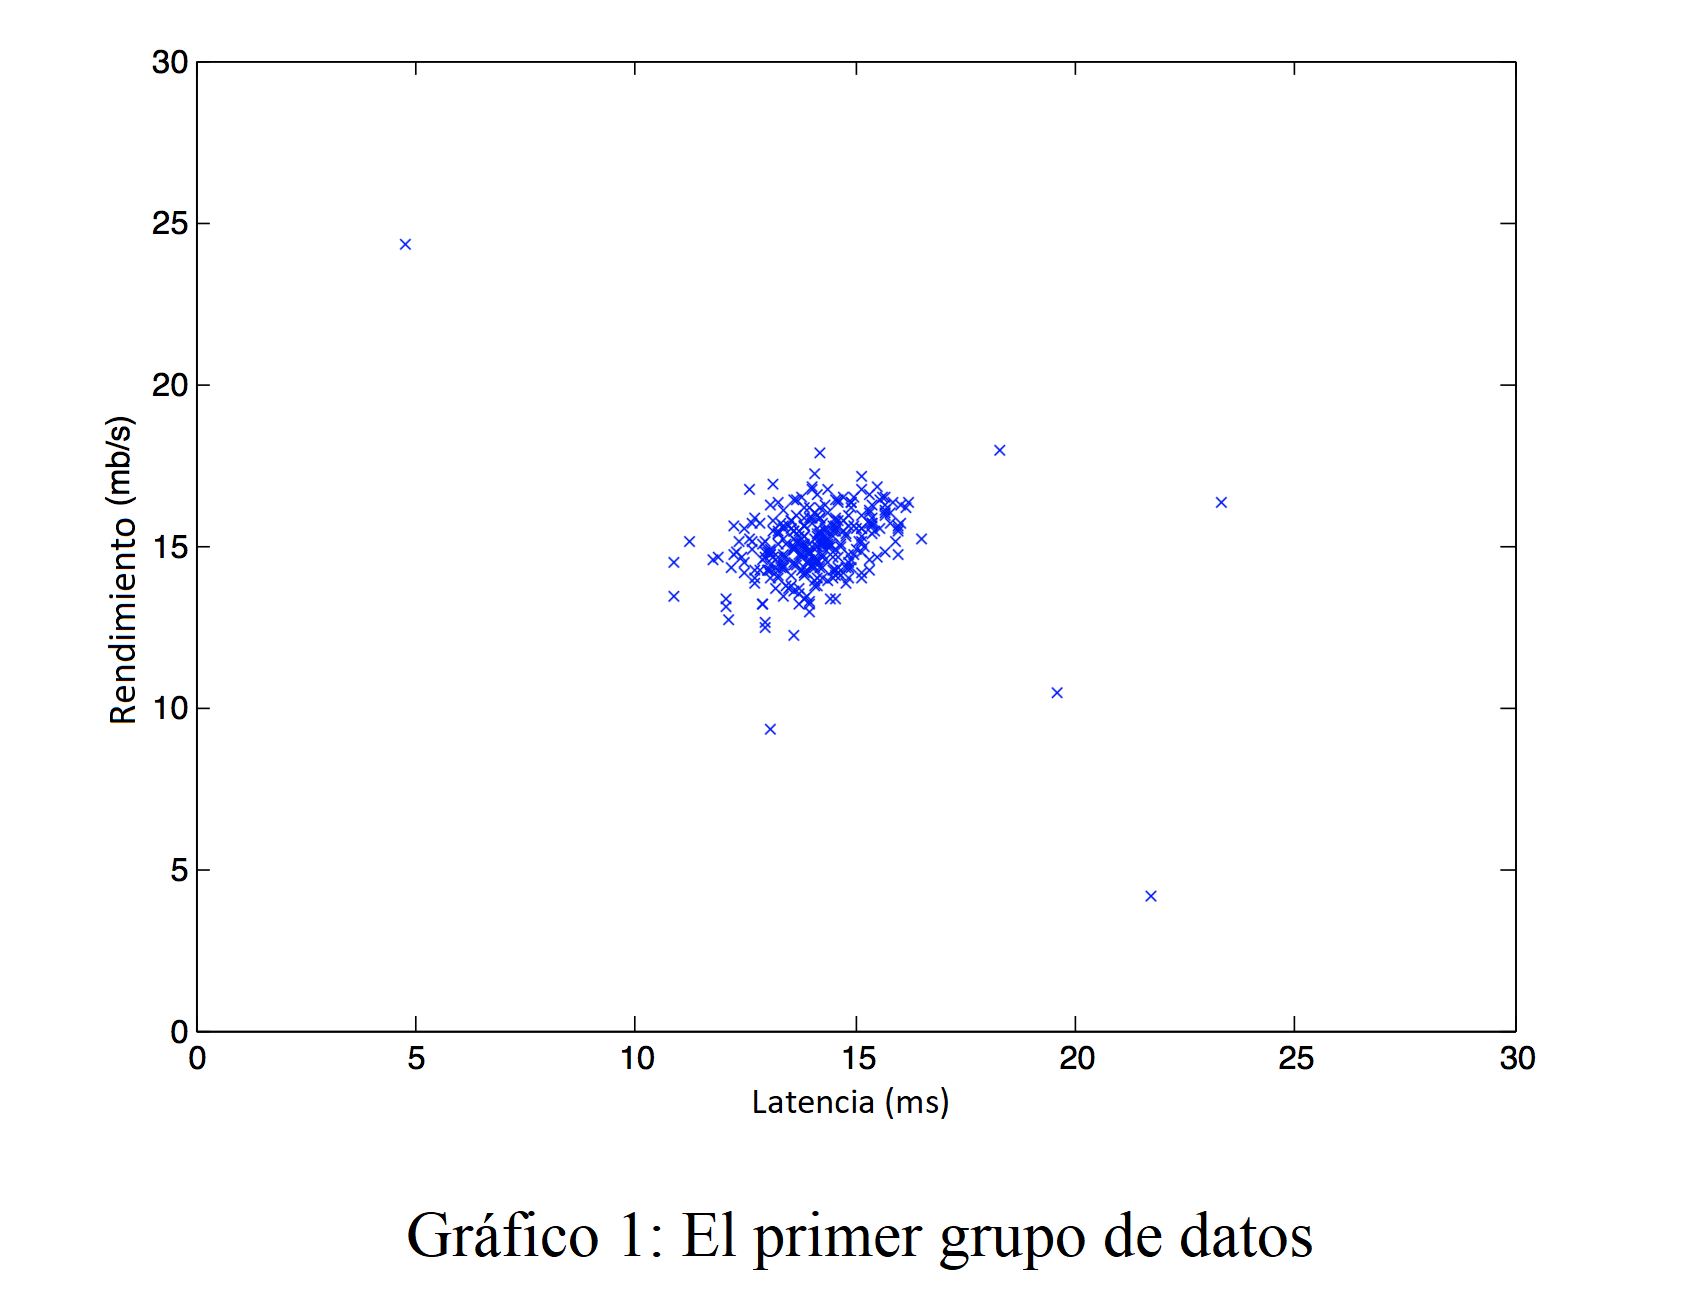

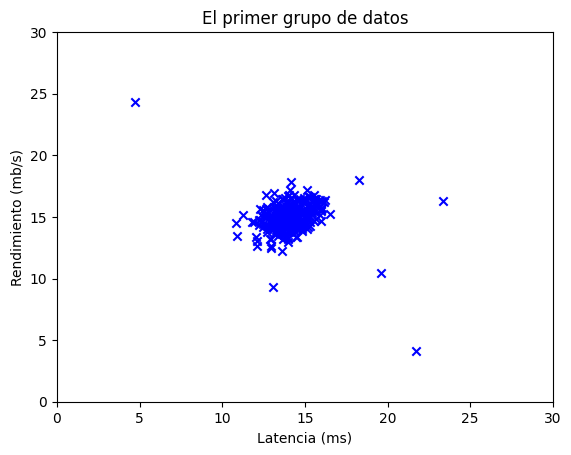

In [7]:
# Crear un diagrama de dispersión de los datos. Para cambiar los marcadores a "x" azul,
# usamos los parámetros 'marker' y 'c'
plt.scatter(X_train[:, 0], X_train[:, 1], marker='x', c='b') 

# Definir el título
plt.title("El primer grupo de datos")
# Definir la etiqueta del eje y
plt.ylabel('Rendimiento (mb/s)')
# Definir la etiqueta del eje x
plt.xlabel('Latencia (ms)')
# Definir el rango de los ejes
plt.axis([0, 30, 0, 30])
plt.show()

<a name="2.3"></a>
### 2.3 Distribución Gaussiana

Para realizar la detección de anomalías, primero necesitarás ajustar un modelo a la distribución de los datos.

* Dado un conjunto de entrenamiento $\{x^{(1)}, ..., x^{(m)}\}$ quieres estimar la distribución Gaussiana para cada una de las X características $x_i$.

* Recuerda que la distribución Gaussiana está dada por

   $$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$

   donde $\mu$ es la media y $\sigma^2$ es la varianza.
   
* Para cada X característica $i = 1\ldots n$, necesitas encontrar los parámetros $\mu_i$ y $\sigma_i^2$ que se ajusten a los datos en la dimensión $i$ $\{x_i^{(1)}, ..., x_i^{(m)}\}$ (la dimensión $i$ de cada ejemplo).

### 2.3.1 Estimando parámetros para una distribución Gaussiana

**Implementación**: 

Tu tarea es completar el código en `estimate_gaussian` a continuación.

<a name="ex01"></a>
### Ejercicio 1

Por favor, completa la función `estimate_gaussian` a continuación para calcular `mu` (media para cada X característica en `X`) y `var` (varianza para cada X característica en `X`).

Puedes estimar los parámetros, ($\mu_i$, $\sigma_i^2$), de la $i$-ésima X característica usando las siguientes ecuaciones. Para estimar la media, usarás:

$$\mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}$$

y para la varianza usarás:
$$\sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$

Si te quedas atascado, puedes consultar las pistas presentadas después de la celda siguiente para ayudarte con la implementación.

In [8]:
# UNQ_C1
# FUNCIÓN CALIFICADA: estimate_gaussian

def estimate_gaussian(X): 
    """
    Calcula la media y la varianza de todas las X características 
    en el conjunto de datos
    
    Args:
        X (ndarray): (m, n) Matriz de datos
    
    Returns:
        mu (ndarray): (n,) Media de todas las X características
        var (ndarray): (n,) Varianza de todas las X características
    """

    m, n = X.shape
    
    ### INICIA TU CÓDIGO AQUÍ ###
    
    # Calculamos la media y la varianza para cada característica (columna) del conjunto de datos X.
    # La media (mu) representa el valor promedio observado para cada variable, mientras que la varianza (var)
    # indica qué tanto se dispersan los datos respecto a ese promedio. Estos parámetros son esenciales para
    # ajustar una distribución Gaussiana a cada dimensión, permitiendo modelar el comportamiento "normal"
    # de los datos y detectar desviaciones (anomalías) posteriormente.

    # Media y varianza por característica (columna)
    mu = np.mean(X, axis=0)
    # Varianza no centrada en m (poblacional) como en el curso
    var = np.var(X, axis=0, ddof=0)
### TERMINA TU CÓDIGO AQUÍ ### 
        
    return mu, var

**Explicación (estimate_gaussian):**  
Se calculan media y varianza por característica (columnas) para parametrizar una distribución gaussiana independiente por dimensión:  
\( \mu_j = \frac{1}{m}\sum_{i=1}^m X_{ij} \),  
\( \sigma_j^2 = \frac{1}{m}\sum_{i=1}^m (X_{ij}-\mu_j)^2 \).

<details>
  <summary><font size="3" color="darkgreen"><b>Haz clic para ver pistas</b></font></summary>
  
   * Puedes implementar esta función de dos maneras:
      * 1 - usando dos bucles anidados - uno recorriendo las **columnas** de `X` (cada X característica) y luego recorriendo cada punto de datos.
      * 2 - de manera vectorizada usando `np.sum()` con el parámetro `axis = 0` (ya que queremos la suma para cada columna)

   * Así puedes estructurar la implementación general de esta función para la implementación vectorizada:
```python  
    def estimate_gaussian(X): 
        m, n = X.shape
    
        ### INICIA TU CÓDIGO AQUÍ ### 
        mu = # Tu código aquí para calcular la media de cada X característica
        var = # Tu código aquí para calcular la varianza de cada X característica 
        ### TERMINA TU CÓDIGO AQUÍ ### 
        
        return mu, var
```

* Si aún tienes dudas, puedes consultar las pistas presentadas abajo para saber cómo calcular `mu` y `var`.
    
    <details>
          <summary><font size="2" color="darkblue"><b>Pista para calcular mu</b></font></summary>
           &emsp; &emsp; Puedes usar <a href="https://numpy.org/doc/stable/reference/generated/numpy.sum.html">np.sum</a> con el parámetro `axis = 0` para obtener la suma de cada columna de un arreglo (array). Dale click al link de np.sum para más pistas.
    </details>
    
    <details>
          <summary><font size="2" color="darkblue"><b>Pista para calcular var</b></font></summary>
           &emsp; &emsp; Puedes usar <a href="https://numpy.org/doc/stable/reference/generated/numpy.sum.html">np.sum</a> con el parámetro `axis = 0` para obtener la suma de cada columna de un arreglo(array) y <code>**2</code> para obtener el cuadrado. Dale click al link de np.sum para más pistas.   
    </details>
    
</details>

Puedes comprobar si tu implementación es correcta ejecutando el siguiente código de prueba:

In [9]:
# Estimar la media y la varianza de cada X característica
mu, var = estimate_gaussian(X_train)              

print("Media de cada X característica:", mu)
print("Varianza de cada X característica:", var)
    
# La prueba unitaria verifica que la función estimate_gaussian calcule correctamente la media y varianza de cada característica.
# Si la salida coincide con los valores esperados, confirma que la implementación es correcta y que los parámetros gaussianos se ajustan adecuadamente a los datos.

# Resultados obtenidos:
# Media de cada X característica: [14.11222578 14.99771051]
# Varianza de cada X característica: [1.83263141 1.70974533]
# Estos valores coinciden con la salida esperada, lo que valida la correcta estimación de los parámetros gaussianos.

# PRUEBA UNITARIA
from public_tests import *
estimate_gaussian_test(estimate_gaussian)

Media de cada X característica: [14.11222578 14.99771051]
Varianza de cada X característica: [1.83263141 1.70974533]
All tests passed!


**Salida esperada**:

| Media de cada X característica: | [14.11222578 14.99771051] |
|---------------------------------|--------------------------|
| Varianza de cada X característica: | [1.83263141 1.70974533] |

Ahora que has completado el código en `estimate_gaussian`, visualizaremos los contornos de la distribución Gaussiana ajustada.

Deberías obtener un gráfico similar a la figura de abajo.
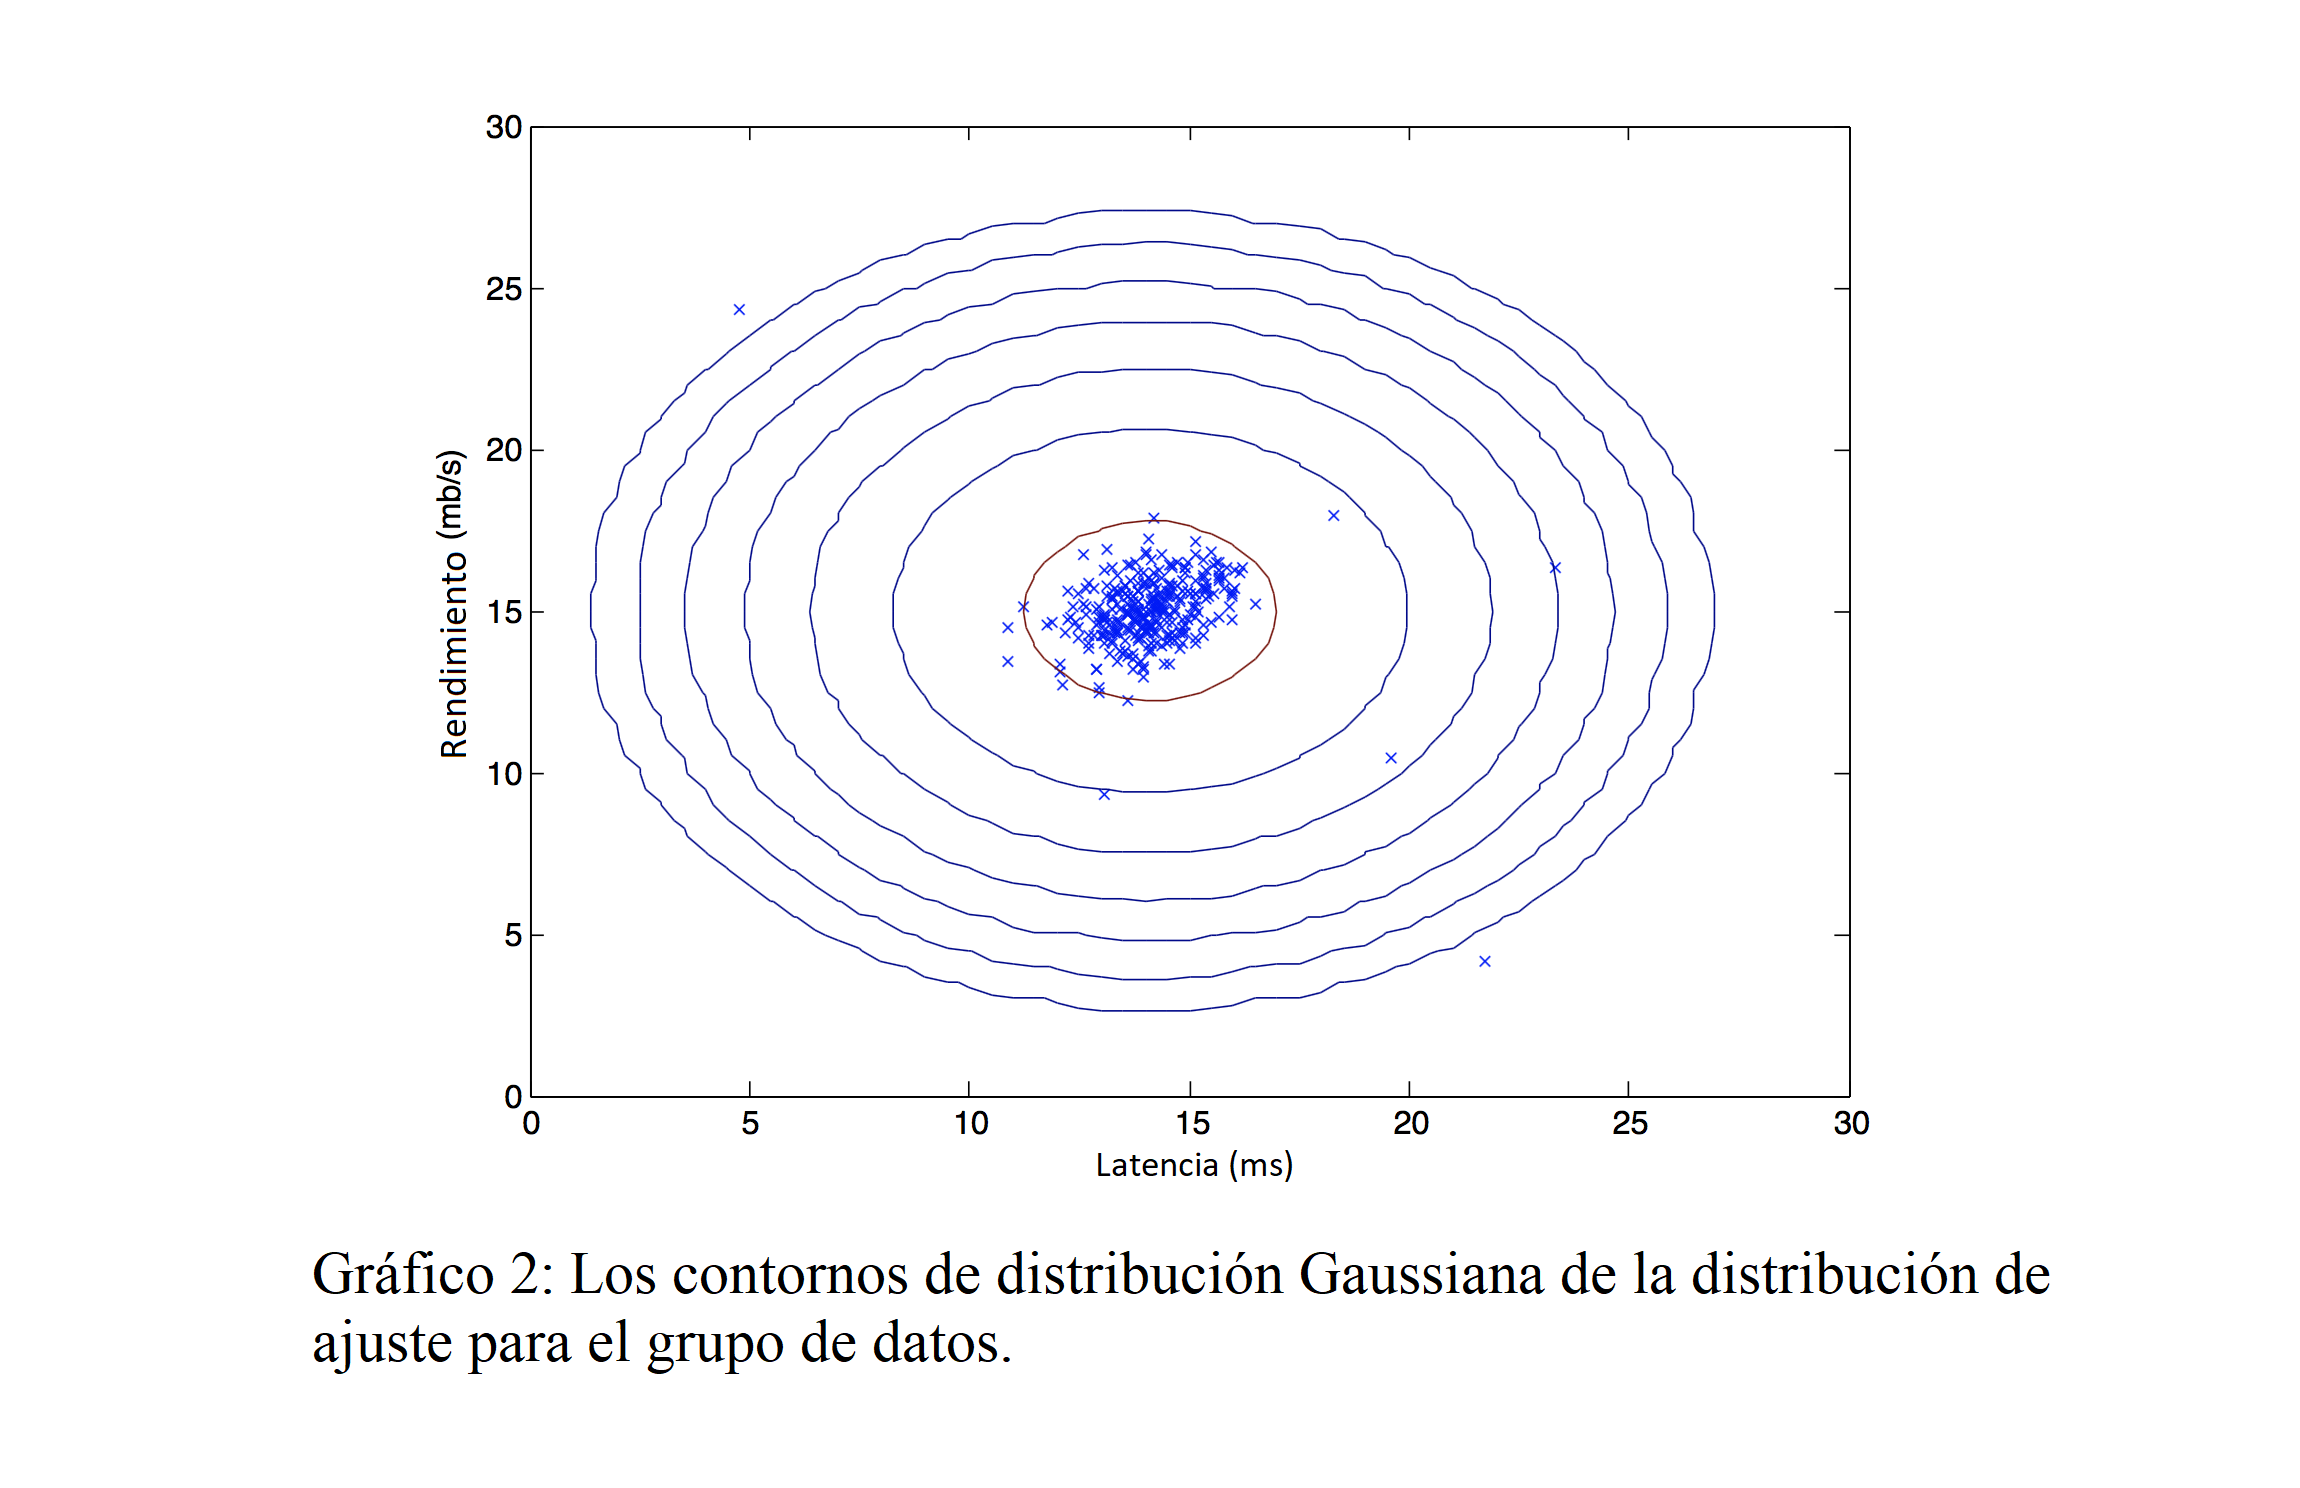

En tu gráfico puedes ver que la mayoría de los ejemplos están en la región con mayor probabilidad, mientras que los ejemplos anómalos están en las regiones con menor probabilidad.

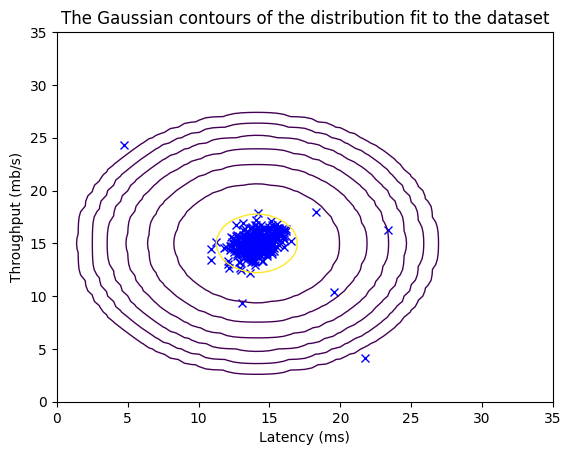

In [10]:
# Devuelve la densidad de la normal multivariante
# en cada punto de datos (fila) de X_train
p = multivariate_gaussian(X_train, mu, var)

#Código para graficar
visualize_fit(X_train, mu, var)

### 2.3.2 Seleccionando el umbral $\epsilon$

Ahora que has estimado los parámetros Gaussianos, puedes investigar qué ejemplos tienen una probabilidad muy alta dada esta distribución y qué ejemplos tienen una probabilidad muy baja.

* Los ejemplos de baja probabilidad son más propensos a ser las anomalías en nuestro conjunto de datos.
* Una forma de determinar qué ejemplos son anomalías es seleccionar un umbral basado en un conjunto de validación cruzada.

En esta sección, completarás el código en `select_threshold` para seleccionar el umbral $\varepsilon$ usando el puntaje $F_1$ en un conjunto de validación cruzada.

* Para esto, usaremos un conjunto de validación cruzada
$\{(x_{\rm cv}^{(1)}, y_{\rm cv}^{(1)}),\ldots, (x_{\rm cv}^{(m_{\rm cv})}, y_{\rm cv}^{(m_{\rm cv})})\}$, donde la etiqueta $y=1$ corresponde a un ejemplo anómalo, y $y=0$ corresponde a un ejemplo normal.
* Para cada ejemplo de validación cruzada, calcularemos $p(x_{\rm cv}^{(i)})$. El vector de todas estas probabilidades $p(x_{\rm cv}^{(1)}), \ldots, p(x_{\rm cv}^{(m_{\rm cv})})$ se pasa a `select_threshold` en el vector `p_val`.
* Las etiquetas correspondientes $y_{\rm cv}^{(1)}, \ldots, y_{\rm cv}^{(m_{\rm cv})}$ se pasan a la misma función en el vector `y_val`.

<a name="ex02"></a>
### Ejercicio 2
Por favor, completa la función `select_threshold` a continuación para encontrar el mejor umbral a usar para seleccionar valores atípicos basados en los resultados del conjunto de validación (`p_val`) y la verdad de terreno (`y_val`).

* En el código proporcionado `select_threshold`, ya hay un bucle que probará muchos valores diferentes de $\varepsilon$ y seleccionará el mejor $\varepsilon$ basado en el puntaje $F_1$.

* Debes implementar el código para calcular el puntaje F1 al elegir `epsilon` como el umbral y colocar el valor en `F1`.

  * Recuerda que si un ejemplo $x$ tiene una probabilidad baja $p(x) < \varepsilon$, entonces se clasifica como una anomalía.
        
  * Luego, puedes calcular precisión y recall por:
   $$\begin{aligned}
   prec&=&\frac{tp}{tp+fp}\\
   rec&=&\frac{tp}{tp+fn},
   \end{aligned}$$ donde
    * $tp$ es el número de verdaderos positivos: la etiqueta de la verdad de terreno dice que es una anomalía y nuestro algoritmo lo clasificó correctamente como anomalía.
    * $fp$ es el número de falsos positivos: la etiqueta de la verdad de terreno dice que no es una anomalía, pero nuestro algoritmo lo clasificó incorrectamente como anomalía.
    * $fn$ es el número de falsos negativos: la etiqueta de la verdad de terreno dice que es una anomalía, pero nuestro algoritmo lo clasificó incorrectamente como no anómalo.

  * El puntaje $F_1$ se calcula usando precisión ($prec$) y recall ($rec$) de la siguiente manera:
    $$F_1 = \frac{2\cdot prec \cdot rec}{prec + rec}$$ 

**Nota de implementación:**
Para calcular $tp$, $fp$ y $fn$, puedes usar una implementación vectorizada en lugar de recorrer todos los ejemplos.


Si te atascas, puedes consultar las pistas presentadas después de la celda siguiente para ayudarte con la implementación.

In [11]:
# UNQ_C2
# FUNCIÓN CALIFICADA: select_threshold

def select_threshold(y_val, p_val): 
    """
    Encuentra el mejor umbral a usar para seleccionar valores atípicos
    basado en los resultados de un conjunto de validación (p_val)
    y la verdad de terreno (y_val)
    
    Args:
        y_val (ndarray): Verdad de terreno en el conjunto de validación
        p_val (ndarray): Resultados en el conjunto de validación
        
    Returns:
        epsilon (float): Umbral elegido
        F1 (float):      Puntaje F1 al elegir epsilon como umbral
    """ 

    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
    
        ### INICIA TU CÓDIGO AQUÍ ###
        
        # En cada iteración, el código calcula las métricas de desempeño para un posible umbral de detección de anomalías.
        # Primero, genera las predicciones: si la probabilidad estimada para un ejemplo es menor que el umbral (epsilon), se clasifica como anómalo (1), 
        # de lo contrario como normal (0).
        # Luego, compara estas predicciones con las etiquetas reales del conjunto de validación para contar los verdaderos positivos (tp: 
        # anomalía detectada correctamente), falsos positivos (fp: normal clasificado erróneamente como anomalía) y falsos negativos (fn: anomalía no detectada).
        # Con estos valores, calcula la precisión (proporción de predicciones de anomalía correctas), el recall (proporción de anomalías reales detectadas) 
        # y el puntaje F1, que combina ambas métricas para evaluar el balance entre precisión y recall.

        # Predicción de anómalos según el umbral actual
        preds = (p_val < epsilon).astype(int)

        # Cálculo de TP, FP y FN
        tp = np.sum((preds == 1) & (y_val == 1))
        fp = np.sum((preds == 1) & (y_val == 0))
        fn = np.sum((preds == 0) & (y_val == 1))

        # Precisión, recall y F1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        F1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        ### TERMINA TU CÓDIGO AQUÍ ### 
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

**Explicación (select_threshold):**  
Se barre el umbral \(\epsilon\) sobre \(p\_val\); se predice anomalía si \(p(x) < \epsilon\).  
Con las etiquetas reales \(y\_val\), se calculan TP/FP/FN, luego precisión, recall y F1.  
Se conserva el \(\epsilon\) que maximiza el F1.

<details>
  <summary><font size="3" color="darkgreen"><b>Haz clic para ver pistas</b></font></summary>

   * Así puedes estructurar la implementación general de esta función para la implementación vectorizada:
```python  
    def select_threshold(y_val, p_val): 
        best_epsilon = 0
        best_F1 = 0
        F1 = 0
    
        step_size = (max(p_val) - min(p_val)) / 1000
    
        for epsilon in np.arange(min(p_val), max(p_val), step_size):
    
            ### INICIA TU CÓDIGO AQUÍ ### 
            predictions = # Tu código aquí para calcular las predicciones para cada ejemplo usando epsilon como umbral
        
            tp = # Tu código aquí para calcular el número de verdaderos positivos
            fp = # Tu código aquí para calcular el número de falsos positivos
            fn = # Tu código aquí para calcular el número de falsos negativos
        
            prec = # Tu código aquí para calcular la precisión
            rec = # Tu código aquí para calcular el recall
        
            F1 = # Tu código aquí para calcular F1
            ### TERMINA TU CÓDIGO AQUÍ ### 
        
            if F1 > best_F1:
                best_F1 = F1
                best_epsilon = epsilon
        
        return best_epsilon, best_F1
```

* Si aún tienes dudas, puedes consultar las pistas presentadas abajo para saber cómo calcular cada variable.
    
    <details>
          <summary><font size="2" color="darkblue"><b>Pista para calcular predictions</b></font></summary>
           &emsp; &emsp; Si un ejemplo  $x$  tiene una probabilidad baja  $p(x) < \epsilon$ , entonces se clasifica como una anomalía. Para obtener las predicciones para cada ejemplo (0/ False para normal y 1/True para anomalía), puedes usar <code>predictions = (p_val < epsilon)</code>
    </details>
    
    <details>
          <summary><font size="2" color="darkblue"><b>Pista para calcular tp, fp, fn</b></font></summary>
           &emsp; &emsp; 
        <ul>
          <li>Si tienes varios valores binarios en un vector binario de dimensión $n$, puedes averiguar cuántos valores en este vector son 0 usando: `np.sum(v == 0)`</li>
          <li>También puedes aplicar un operador lógico *and* a tales vectores binarios. Por ejemplo,  `predictions` es un vector binario del tamaño de tu número de conjunto de validación cruzada, donde el elemento $i$ es 1 si tu algoritmo considera $x_{\rm cv}^{(i)}$ una anomalía, y 0 en caso contrario. </li>
          <li>Puedes entonces, por ejemplo, calcular el número de falsos positivos usando:  
            <code>fp = sum((predictions == 1) & (y_val == 0))</code>.</li>
        </ul>
         <details>
              <summary><font size="2" color="blue"><b>&emsp; &emsp; Más pistas para calcular tp, fn</b></font></summary>
               &emsp; &emsp;
             <ul>
              <li>Puedes calcular tp como <code> tp = np.sum((predictions == 1) & (y_val == 1))</code></li>
              <li>Puedes calcular fn como <code> fn = np.sum((predictions == 0) & (y_val == 1))</code></li>  
              </ul>
          </details>
    </details>    
</details>

Puedes comprobar tu implementación usando el siguiente código

In [12]:
p_val = multivariate_gaussian(X_val, mu, var)
epsilon, F1 = select_threshold(y_val, p_val)

print('Mejor epsilon encontrado usando validación cruzada: %e' % epsilon)
print('Mejor F1 en el conjunto de validación cruzada: %f' % F1)
  
# Explicación:
# El código calcula el umbral óptimo (epsilon) para detectar anomalías usando el conjunto de validación cruzada.
# Se evalúan diferentes valores de epsilon y se selecciona aquel que maximiza el puntaje F1, que balancea precisión y recall.
# El resultado obtenido indica que el mejor epsilon encontrado es 8.99e-05, lo que significa que los ejemplos con probabilidad menor a este valor se consideran anomalías.
# El puntaje F1 de 0.875 refleja un excelente equilibrio entre la detección de anomalías reales y la minimización de falsos positivos, 
# mostrando que el modelo es efectivo para separar ejemplos normales de anómalos en este conjunto de datos.

# PRUEBA UNITARIA
select_threshold_test(select_threshold)


Mejor epsilon encontrado usando validación cruzada: 8.990853e-05
Mejor F1 en el conjunto de validación cruzada: 0.875000
All tests passed!


**Salida esperada**:

| Mejor epsilon encontrado usando validación cruzada: | 8.99e-05 |
|----------------------------------------------------|----------|
| Mejor F1 en el conjunto de validación cruzada:     | 0.875    |

Ahora ejecutaremos tu código de detección de anomalías y encerraremos las anomalías en el gráfico (Figura 3 abajo).

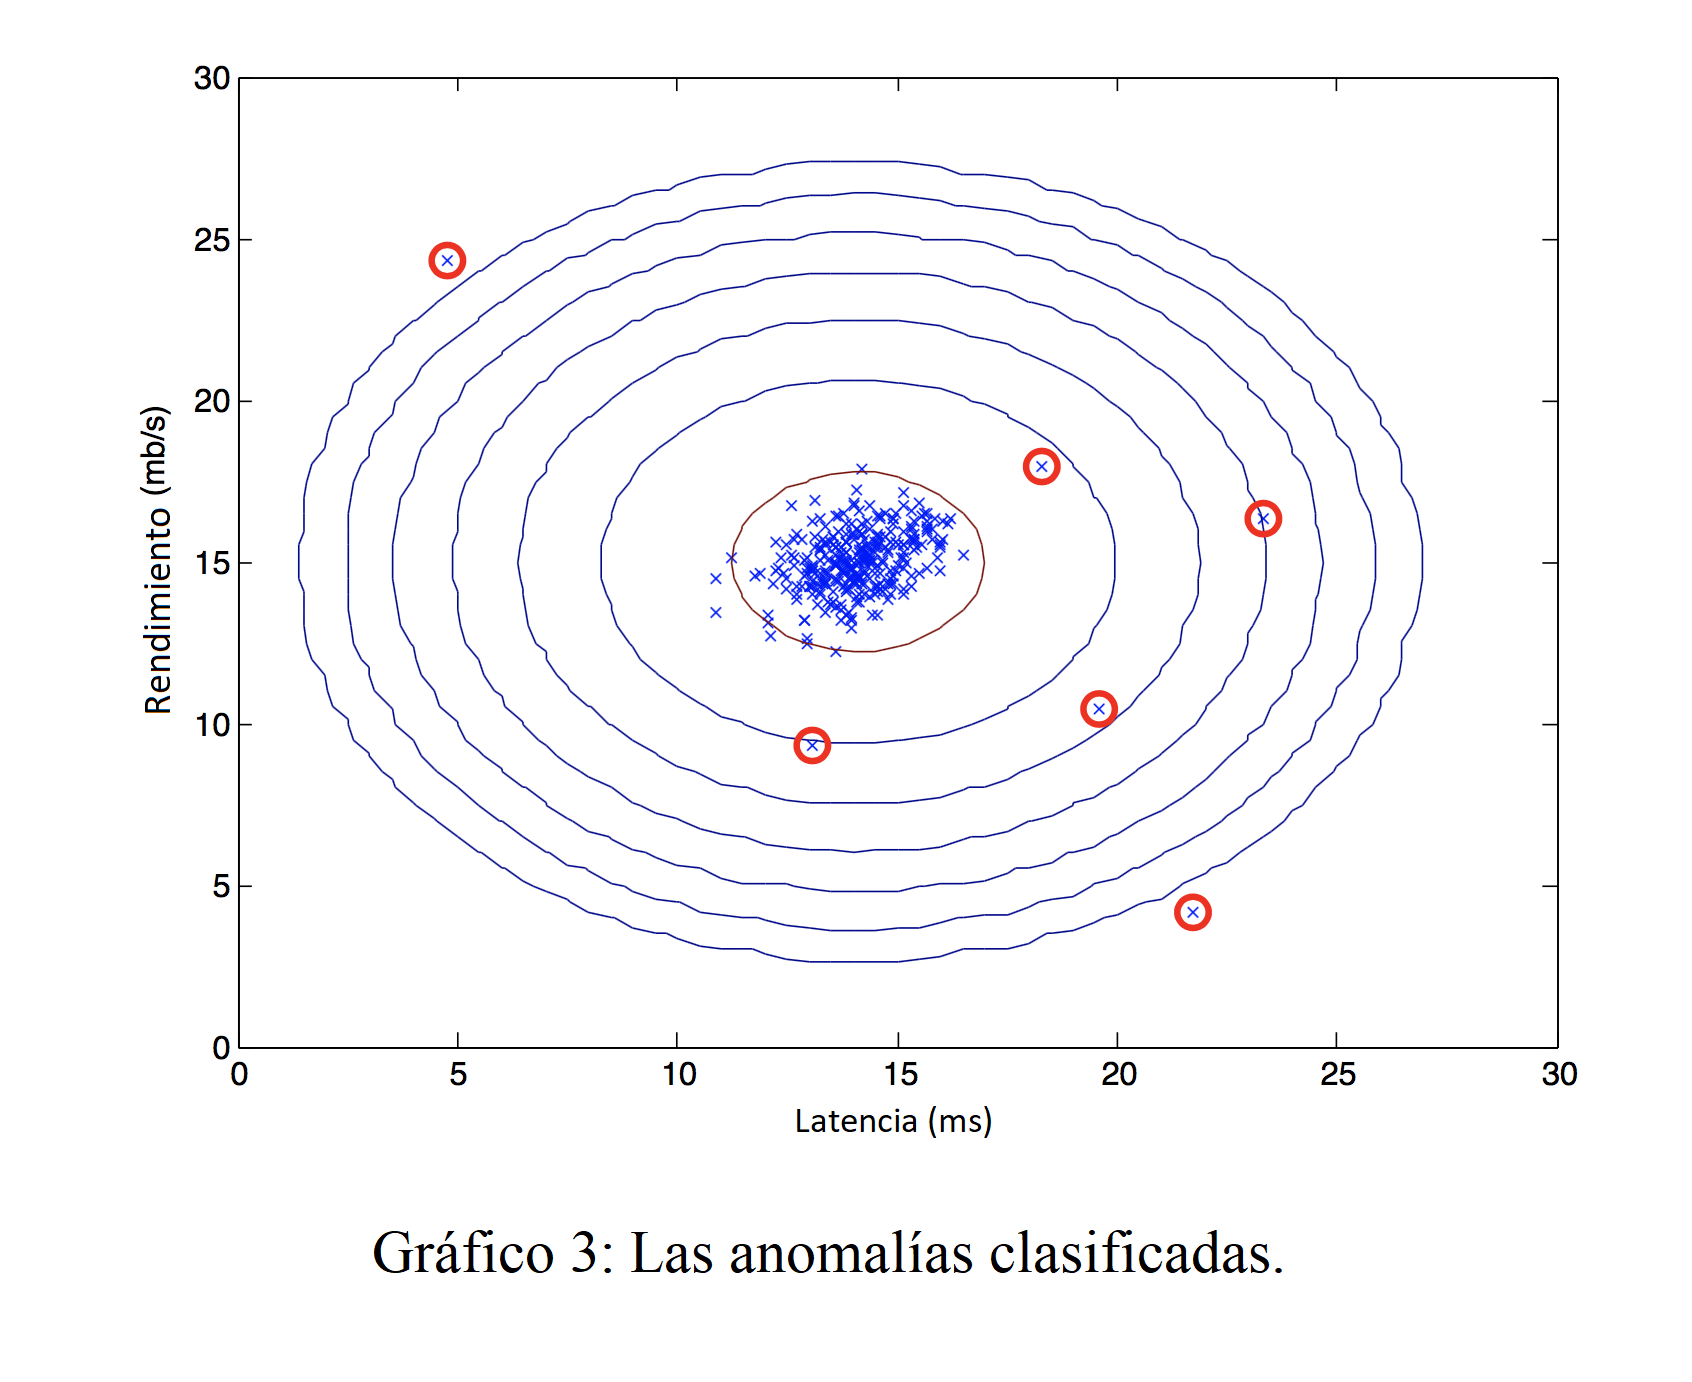

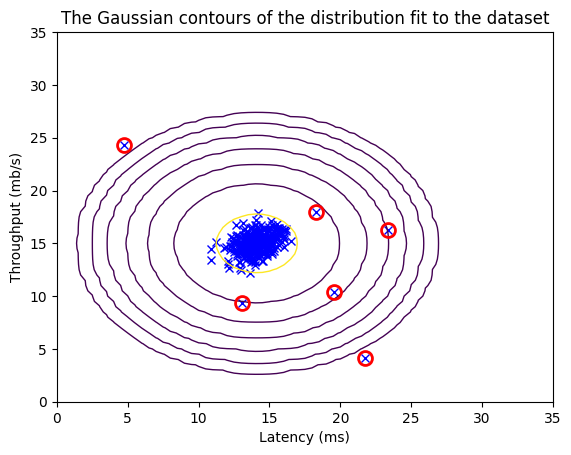

In [13]:
# Encontrar los valores atípicos en el conjunto de entrenamiento
outliers = p < epsilon

# Visualizar el ajuste
visualize_fit(X_train, mu, var)

# Dibujar un círculo rojo alrededor de esos valores atípicos
plt.plot(X_train[outliers, 0], X_train[outliers, 1], 'ro',
         markersize= 10,markerfacecolor='none', markeredgewidth=2)

<a name="2.4"></a>
### 2.4 Conjunto de datos de alta dimensión

Ahora, ejecutaremos el algoritmo de detección de anomalías que implementaste en un conjunto de datos más realista y mucho más difícil.

En este conjunto de datos, cada ejemplo está descrito por 11 X características, capturando muchas más propiedades de tus servidores.

Comencemos cargando el conjunto de datos.

- La función `load_data()` que se muestra a continuación carga los datos en las variables `X_train_high`, `X_val_high` y `y_val_high`
    -  `_high` sirve para distinguir estas variables de las usadas en la parte anterior
    - Usaremos `X_train_high` para ajustar la distribución Gaussiana
    - Usaremos `X_val_high` y `y_val_high` como conjunto de validación cruzada para seleccionar un umbral y determinar ejemplos anómalos vs normales

In [14]:
# Cargar el conjunto de datos
X_train_high, X_val_high, y_val_high = load_data_multi()

#### Verifica la forma(shape) de tus variables

Verifiquemos la forma(shape) de estas nuevas variables para familiarizarnos con los datos

In [15]:
print ('La forma(shape) de X_train_high es:', X_train_high.shape)
print ('La forma(shape) de X_val_high es:', X_val_high.shape)
print ('La forma(shape) de y_val_high es: ', y_val_high.shape)

La forma(shape) de X_train_high es: (1000, 11)
La forma(shape) de X_val_high es: (100, 11)
La forma(shape) de y_val_high es:  (100,)


#### Detección de anomalías 

Ahora, ejecutemos el algoritmo de detección de anomalías en este nuevo conjunto de datos.

El siguiente código usará tu código para:
* Estimar los parámetros Gaussianos ($\mu_i$ y $\sigma_i^2$)
* Evaluar las probabilidades tanto para los datos de entrenamiento `X_train_high` de los cuales estimaste los parámetros Gaussianos, como para el conjunto de validación cruzada `X_val_high`.
* Finalmente, usará `select_threshold` para encontrar el mejor umbral $\varepsilon$.

In [16]:
# Aplicar los mismos pasos al conjunto de datos más grande

# Estimar los parámetros Gaussianos
mu_high, var_high = estimate_gaussian(X_train_high)

# Evaluar las probabilidades para el conjunto de entrenamiento
p_high = multivariate_gaussian(X_train_high, mu_high, var_high)

# Evaluar las probabilidades para el conjunto de validación cruzada
p_val_high = multivariate_gaussian(X_val_high, mu_high, var_high)

# Encontrar el mejor umbral
epsilon_high, F1_high = select_threshold(y_val_high, p_val_high)

print('Mejor epsilon encontrado usando validación cruzada: %e'% epsilon_high)
print('Mejor F1 en el conjunto de validación cruzada:  %f'% F1_high)
print('# Anomalías encontradas: %d'% sum(p_high < epsilon_high))

# El umbral se selecciona maximizando el F1 en validación cruzada, lo que garantiza un buen equilibrio entre precisión y recall en la detección de anomalías.
# Mejor epsilon encontrado usando validación cruzada: 1.377229e-18
# Mejor F1 en el conjunto de validación cruzada:  0.615385
# # Anomalías encontradas: 117

Mejor epsilon encontrado usando validación cruzada: 1.377229e-18
Mejor F1 en el conjunto de validación cruzada:  0.615385
# Anomalías encontradas: 117


**Salida esperada**:

| Mejor epsilon encontrado usando validación cruzada: | 1.38e-18 |
|----------------------------------------------------|----------|
| Mejor F1 en el conjunto de validación cruzada:     | 0.615385 |
| # anomalías encontradas:                           | 117      |

## Conclusiones del ejercicio sobre Detección de Anomalías

### Conclusión de fragmentos de código relevantes

- **`estimate_gaussian(X)`**  
  Calcula **media** y **varianza** por característica para parametrizar un modelo Gaussiano independiente por dimensión. Es la base para estimar la probabilidad de cada punto bajo el patrón “normal”.

- **Cálculo de probabilidades**  
  Con los parámetros anteriores, el notebook evalúa la **densidad** de cada ejemplo asumiendo independencia entre variables (producto de gaussianas univariadas). Los puntos con probabilidad baja son candidatos a anomalías.

- **`select_threshold(y_val, p_val)`**  
  Recorre umbrales (`epsilon`) y, usando el conjunto de validación con etiquetas, calcula **precisión**, **recobrado** y **F1** para elegir el umbral que mejor separa normales de atípicos. Este paso equilibra falsos positivos y falsos negativos.

- **Visualización y validación**  
  Las figuras permiten contrastar las regiones de alta densidad con los puntos marcados como anómalos y verificar que el umbral resulte coherente con los datos y con `y_val`.

### Conclusión final de la actividad

El flujo implementado deja claro que detectar anomalías es un **problema de umbral** sobre una función de probabilidad aprendida a partir de datos “sanos”. El rendimiento depende de una buena estimación de parámetros y de una **selección de umbral** guiada por la métrica adecuada (F1 en escenarios desbalanceados). La interpretación visual y la revisión de verdaderos/ falsos positivos resultaron claves para ajustar el criterio sin sobre-ajustar.

---

<div style="background:#c8f7c5;padding:14px;border-left:6px solid #2e7d32;color:#111;">
  <h3 style="margin:0 0 8px 0;">Elementos importantes a tener en cuenta</h3>
  <ul style="margin:0 0 0 18px;">
    <li><strong>Independencia de variables:</strong> el supuesto simplifica el modelo; si hay correlaciones fuertes, considerar PCA o gaussiana multivariante.</li>
    <li><strong>Escalado:</strong> estandarizar evita que una variable con gran varianza diluya la señal de rareza.</li>
    <li><strong>Desbalance:</strong> las anomalías son raras; F1 es preferible a exactitud.</li>
    <li><strong>Estabilidad numérica:</strong> con probabilidades muy pequeñas, usar espacios logarítmicos si se requiere escalar.</li>
    <li><strong>Validación:</strong> separar validación/serving; el umbral elegido debe reevaluarse cuando cambie la distribución.</li>
  </ul>
</div>

<div style="background:#e3f2fd;padding:14px;border-left:6px solid #1565c0;color:#0b2c4d;margin-top:14px;">
  <h3 style="margin:0 0 8px 0;">Lecciones aprendidas</h3>
  <ul style="margin:0 0 0 18px;">
    <li>La detección efectiva no depende solo del modelo; el <strong>umbral</strong> es tan importante como la estimación.</li>
    <li>La inspección de <em>confusion matrix</em> y casos frontera ayuda a ajustar el costo relativo de errores.</li>
    <li>En datos con deriva, conviene <strong>re-entrenar</strong> parámetros y recalibrar el umbral de forma periódica.</li>
  </ul>
</div>

<div style="background:#ffebee;padding:14px;border-left:6px solid #c62828;color:#3b0d0d;margin-top:14px;">
  <h3 style="margin:0 0 8px 0;">Impacto en el día a día y valor para la industria</h3>
  <ul style="margin:0 0 0 18px;">
    <li><strong>Fraude y transacciones:</strong> alertas tempranas en pagos, devoluciones y beneficios anómalos.</li>
    <li><strong>Operaciones y SRE:</strong> detección de picos inusuales en latencia/errores a partir de métricas de servicio.</li>
    <li><strong>Calidad de datos:</strong> identificar registros corruptos o desviaciones en pipelines.</li>
    <li><strong>Importancia en los roles de tecnología:</strong> habilita <em>guardrails</em> en producción (monitoreo con umbrales adaptativos) y priorización de incidentes con evidencia cuantitativa, lo que agrega <strong>valor diferenciador</strong> en proyectos con SLA estrictos.</li>
  </ul>
</div>

<br>

**Realizado por:**  
Cindy Liliana Vargas Duque  
Jesús Ariel González Bonilla
